In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

In [45]:
def df_generator(df_exp_data, df_num_data, binding_site):

	num_muts = []
	num_mut_sites = [] 
	binding_site_idx = [] 
	for mut in df_num_data["mutations"].to_numpy():
		num_muts.append(mut.split("_")[0])
		num_mut_sites.append(int(mut.split("_")[0][1:-1])) #just get numerical value
	sorting_idx = np.argsort(num_mut_sites)
	num_muts = np.array(num_muts)[sorting_idx] #just sort by binding site 
	for mut in binding_site : 
		binding_site_idx.append(np.where(num_muts == mut )[0] [0]) 

	exp_muts_np = df_exp_data["mutation"].to_numpy()
	idx= []  
	for mut in num_muts : 
		idx.append(np.where(exp_muts_np == mut )[0] [0]) 
	if np.all(exp_muts_np[idx] == num_muts) == False :      #check here
		print("Error, mutations do not match")
		
	relevant_exp_data = df_exp_data.iloc[idx]["bind_avg"].to_numpy()
	R = 1.98*1e-3 #1e-3 for cal to kcal conversion 
	T =298  #room temp  
	K_D_app = 3.9*1e-11 #from paper 
	delta_g_deg = R * T * np.log(K_D_app)
	tmp_K_mut = 10**(relevant_exp_data) * K_D_app
	delta_g_first_method = -R * T * np.log(tmp_K_mut)

	del_del_g_total = - ( delta_g_deg + delta_g_first_method) 

	df_num_data_sorted= df_num_data.iloc[sorting_idx].copy()
	df_num_data_sorted["exp_data"] = del_del_g_total
	df_num_data_sorted["mutations"] = num_muts
	df_num_data_sorted_binding_site = df_num_data_sorted.iloc[binding_site_idx].copy()
	
		
	#non_binding_df
	mask =np.ones(len(num_muts), dtype=bool)
	mask[binding_site_idx] = 0 #mask the binding site. 
	non_binding_idx = sorting_idx[mask]
	df_num_data_sorted_no_binding_site = df_num_data.iloc[non_binding_idx].copy()
	df_num_data_sorted_no_binding_site["exp_data"] = del_del_g_total[mask]
	df_num_data_sorted_no_binding_site["mutations"] = num_muts[mask]


	return df_num_data_sorted, df_num_data_sorted_binding_site, \
		df_num_data_sorted_no_binding_site,binding_site_idx

In [46]:
def smple_clust(radii, col,  df_num_data_sorted, df_num_data_sorted_binding_site , \
	df_num_data_sorted_no_binding_site, binding_site_idx,  num_clust = 4, plot_command = 0,) : 
	
	all_sites_data          =       -df_num_data_sorted[col]
	binding_site_data       =       -df_num_data_sorted_binding_site[col]
	non_binding_site        =       -df_num_data_sorted_no_binding_site[col]
	
	
	gb5_dat = all_sites_data.to_numpy() 
	# Reshape data for KMeans input (reshape to 2D array)
	gb5_dat_reshape = gb5_dat.reshape(-1, 1)
	# Apply K-means clustering
	kmeans = KMeans(n_clusters=num_clust, random_state=0)
	labels = kmeans.fit_predict(gb5_dat_reshape)
	
	#binding site
	zero_clust_idx = abs(kmeans.cluster_centers_).argmin() #near zero val 
	binding_site_dat = binding_site_data.to_numpy()
	dat_reshape_binding_site = binding_site_dat.reshape(-1, 1)
	labels_binding_site = kmeans.predict(dat_reshape_binding_site)
	model_accuracy = (len(labels_binding_site[labels_binding_site != zero_clust_idx]))\
		/(len(labels_binding_site)) *100
	
	#non_binding site
	non_binding_site_dat = non_binding_site.to_numpy()
	dat_reshape_non_binding_site = non_binding_site_dat.reshape(-1, 1)
	labels_non_binding_site = kmeans.predict(dat_reshape_non_binding_site)
	model_accuracy_FP = (len(labels_non_binding_site[labels_non_binding_site == zero_clust_idx]))\
		/(len(labels_non_binding_site)) *100
	
	non_binding_site
	
	
	if plot_command == 1 :
		#title stuff
		tmp_col = col.split("delta")
		if len(tmp_col) >1 :
			title_str = (col.split("delta")[-1][1:]) + f"_{radii}"
		else:
			title_str = (col.split("_")[0]) + f"_{radii}"
		# Plotting the clusters
		plt.figure(figsize=(8, 6))
		plt.scatter(df_num_data_sorted["mutations"], gb5_dat, c=labels, s=50, cmap='viridis')
		plt.ylabel('ddg')
		tick_positions = np.arange(0, len(df_num_data_sorted["mutations"]), 5)
		tick_labels = [df_num_data_sorted["mutations"].iloc[pos][1:-1] for pos in tick_positions]
		plt.xticks(tick_positions, tick_labels,rotation=45,  fontsize = 8)
		plt.xlabel("site")
		for idx in binding_site_idx:
			plt.axvline(x=idx, color='y', linestyle=':')
		plt.title(f'K-means Clustering {title_str}; {model_accuracy}')
		plt.show()

	return model_accuracy, model_accuracy_FP, num_clust

In [47]:
def corr_plot_gen(radii, df_num_data_sorted, df_num_data_sorted_binding_site, save_fig = 0):
	col_names= ["gb5","gb66", "pb" , "exp"]
 
	#all muts fig
	all_data = np.vstack((-df_num_data_sorted["delta_delta_g_gen"],
		-df_num_data_sorted["delta_delta_g_gen_66"],
		-df_num_data_sorted["delta_delta_g_pb"],
		-df_num_data_sorted["exp_data"]
		)).T

	corr = np.corrcoef(all_data, rowvar=False)
	plt.figure()
	sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=col_names, yticklabels=col_names)
	plt.title(f'Correlation Plot Over All Residues {radii}', fontsize=15)
	plt.xticks(fontsize= 15 )
	plt.yticks(fontsize= 15 )
	if save_fig == 1:
		plt.savefig("corr_all_muts"+f"_{radii}.png")


	#binding site fig
	plt.figure()
	all_data_binding_site = np.vstack((-df_num_data_sorted_binding_site["delta_delta_g_gen"],
		-df_num_data_sorted_binding_site["delta_delta_g_gen_66"],
		-df_num_data_sorted_binding_site["delta_delta_g_pb"],
		-df_num_data_sorted_binding_site["exp_data"]
		)).T
	corr_binding_site = np.corrcoef(all_data_binding_site, rowvar=False)
	sns.heatmap(corr_binding_site, annot=True, cmap='coolwarm', xticklabels=col_names, yticklabels=col_names)
	plt.title(f'Correlation Plot Binding Site {radii}', fontsize=15)
	plt.xticks(fontsize= 15 )
	plt.yticks(fontsize= 15 )
	if save_fig == 1:
		plt.savefig("corr_binding_site"+f"_{radii}.png")

    

In [48]:
def simple_plots(radii : str, df_num_data_sorted, df_num_data_sorted_binding_site ,\
					binding_site_idx, save_fig = 0, ignore_gb5 = False ):
	'''
	radii: name of the raddi (Mbondi, OPT1, OPT2, ect..)
 	df_num_data_sorted
  	df_num_data_sorted_binding_site
	binding_site_idx
	'''
	
	#ALl muts fig
	plt.figure()
	if ignore_gb5 == False :
		plt.scatter( df_num_data_sorted["mutations"]
					,-df_num_data_sorted["delta_delta_g_gen"], label="gb5")
	
	plt.scatter( df_num_data_sorted["mutations"]
				,-df_num_data_sorted["delta_delta_g_gen_66"], label="gb66")
	plt.scatter( df_num_data_sorted["mutations"]
				,-df_num_data_sorted["delta_delta_g_pb"], label="pb")
	plt.scatter( df_num_data_sorted["mutations"]
				,-df_num_data_sorted["exp_data"], label="exp")
				

	tick_positions = np.arange(0, len(df_num_data_sorted["mutations"]), 5)
	tick_labels = [df_num_data_sorted["mutations"].iloc[pos] for pos in tick_positions]
	tick_labels = [df_num_data_sorted["mutations"].iloc[pos][1:-1] for pos in tick_positions]
	
	plt.xticks(tick_positions, tick_labels,rotation=45,  fontsize = 8)
	plt.xlabel("Residue Number", fontsize = 20)
	plt.yticks(fontsize= 15)
	
	for true_idx , idx in enumerate(binding_site_idx):
		if binding_site_idx[true_idx] == binding_site_idx[-1] : #for the last one
			plt.axvline(x=idx, color='y', linestyle=':', label = "Binding Site")
		else:
			plt.axvline(x=idx, color='y', linestyle=':')
	plt.legend()
	plt.title("All mutations"+f"_{radii}", fontsize = 20)
	plt.ylabel(" $\Delta \Delta G$", fontsize = 20)
	plt.tight_layout()
	if save_fig == 1:
		plt.savefig("all_muts_fig"+f"_{radii}.png")
	
	###BINDING SITE FIG
	plt.figure()
	if ignore_gb5 == False :
		plt.scatter( df_num_data_sorted_binding_site["mutations"]
				,-df_num_data_sorted_binding_site["delta_delta_g_gen"], label="gb5")
  
	plt.scatter( df_num_data_sorted_binding_site["mutations"]
				,-df_num_data_sorted_binding_site["delta_delta_g_gen_66"], label="gb66")
	plt.scatter( df_num_data_sorted_binding_site["mutations"]
				,-df_num_data_sorted_binding_site["delta_delta_g_pb"], label="pb")
	plt.scatter( df_num_data_sorted_binding_site["mutations"]
				,-df_num_data_sorted_binding_site["exp_data"], label="exp")
				
	plt.legend()
	plt.title("Mutations on the Binding Site"+f"_{radii}", fontsize = 20)
	plt.ylabel(" $\Delta \Delta G$", fontsize = 20)
	plt.xticks(rotation=45)
	plt.xlabel("Residue",  fontsize = 20)
	plt.tight_layout()
	if save_fig == 1:
		plt.savefig("binding_site_fig"+f"_{radii}.png")
	

In [49]:
binding_site =np.array( ['K417A', 'N439A', 'Y449A', 'Y453A', 'L455A', 'F456A',
	'F486A', 'N487A', 'Y489A', 'Q493A', 'S494A', 'Q498A',
	'T500A', 'N501A', 'V503A', 'Y505A'])

Mbondi Stuff

In [50]:
df_exp_data = pd.read_csv("single_mut_effects.csv")
df_num_data_mbondi = pd.read_csv("all_amino_pb_gb_gb66.csv", index_col=0)
df_num_data_sorted_mbondi, df_num_data_sorted_binding_site_mbondi, \
    df_num_data_sorted_no_binding_site_mbondi, binding_site_idx = \
    df_generator(df_exp_data, df_num_data_mbondi, binding_site)

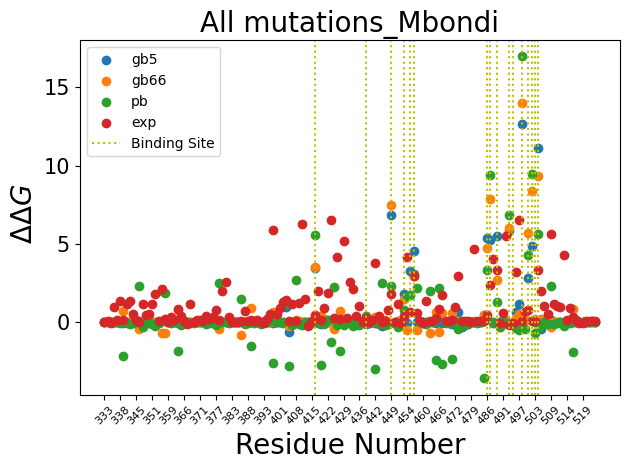

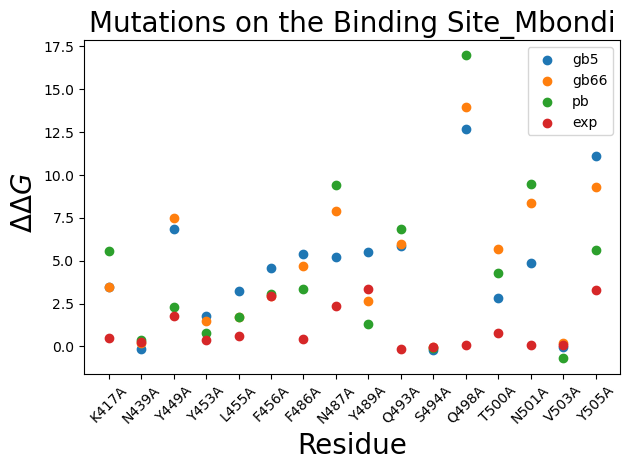

In [51]:
simple_plots("Mbondi",df_num_data_sorted_mbondi, \
    df_num_data_sorted_binding_site_mbondi , binding_site_idx)

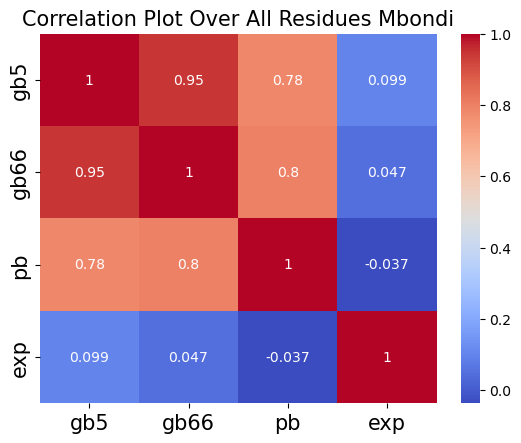

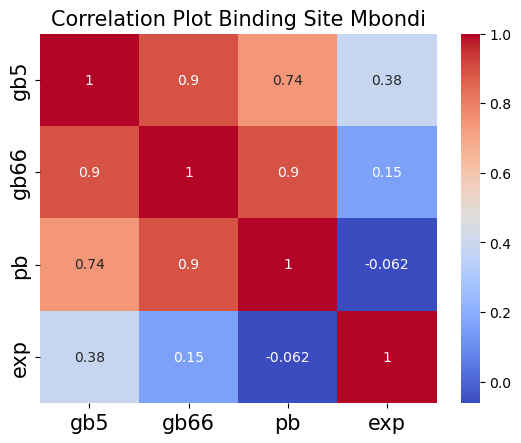

In [52]:
corr_plot_gen("Mbondi", df_num_data_sorted_mbondi, \
    df_num_data_sorted_binding_site_mbondi)

In [53]:
cols_to_test = ["delta_delta_g_gen","delta_delta_g_gen_66","delta_delta_g_pb","exp_data"]
random_state=0 
print(f"{'Model':<25} {'true pos%' :<10}  {'false pos%':<10} {'num_clust':<10}")
num_clust_arr = [2,3,4,5,6,7]
for num_clust in num_clust_arr : 
    for col in cols_to_test :
        model_accuracy, model_accuracy_FP, num_clust_out = smple_clust("Mbondi", col, \
            df_num_data_sorted_mbondi, df_num_data_sorted_binding_site_mbondi , \
                df_num_data_sorted_no_binding_site_mbondi, binding_site_idx, \
                    num_clust=num_clust)
        print(f"{col:<25}: {model_accuracy:<10.4}: {model_accuracy_FP:<10.4} : {num_clust_out}")
    print("-----------------------------------------------------")

Model                     true pos%   false pos% num_clust 
delta_delta_g_gen        : 68.75     : 100.0      : 2
delta_delta_g_gen_66     : 50.0      : 100.0      : 2
delta_delta_g_pb         : 37.5      : 100.0      : 2
exp_data                 : 18.75     : 87.77      : 2
-----------------------------------------------------
delta_delta_g_gen        : 75.0      : 100.0      : 3
delta_delta_g_gen_66     : 68.75     : 100.0      : 3
delta_delta_g_pb         : 75.0      : 89.93      : 3
exp_data                 : 31.25     : 69.78      : 3
-----------------------------------------------------
delta_delta_g_gen        : 81.25     : 100.0      : 4
delta_delta_g_gen_66     : 75.0      : 100.0      : 4
delta_delta_g_pb         : 75.0      : 89.93      : 4
exp_data                 : 37.5      : 62.59      : 4
-----------------------------------------------------
delta_delta_g_gen        : 81.25     : 97.12      : 5
delta_delta_g_gen_66     : 81.25     : 100.0      : 5
delta_delta_g_pb      

OPT1 Stuff

In [54]:
df_num_data_OPT = pd.read_csv("all_amino_salt_pb_OPT.csv", index_col=0)
df_num_data_sorted_OPT, df_num_data_sorted_binding_site_OPT, \
    df_num_data_sorted_no_binding_site_OPT, binding_site_idx_OPT = \
    df_generator(df_exp_data, df_num_data_OPT, binding_site)

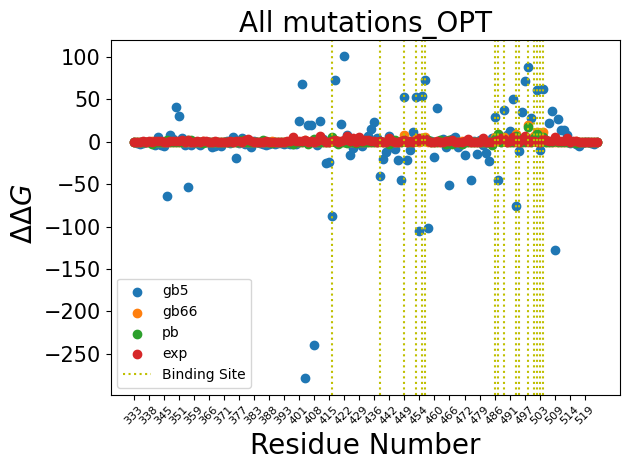

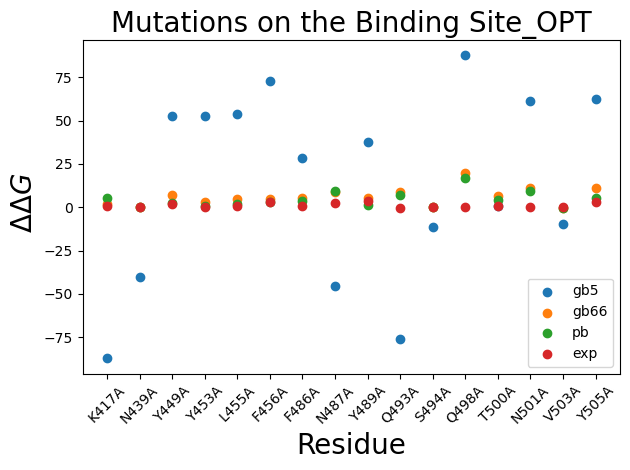

In [55]:
simple_plots("OPT",df_num_data_sorted_OPT, \
    df_num_data_sorted_binding_site_OPT , binding_site_idx_OPT)

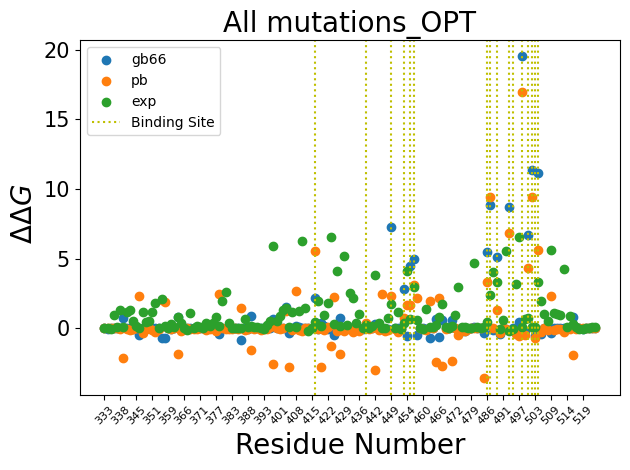

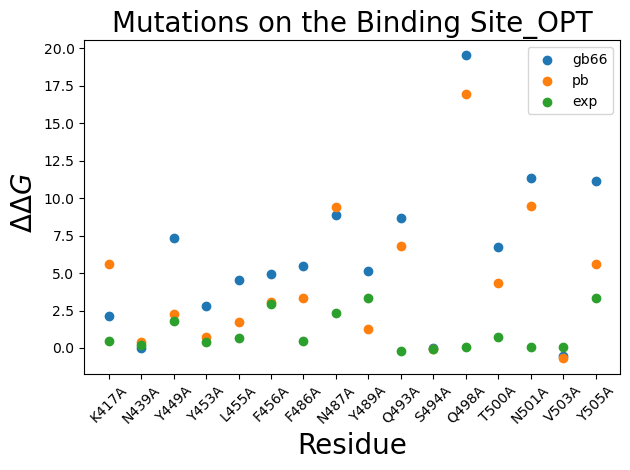

In [56]:

simple_plots("OPT",df_num_data_sorted_OPT, \
    df_num_data_sorted_binding_site_OPT , binding_site_idx_OPT, ignore_gb5 =True)

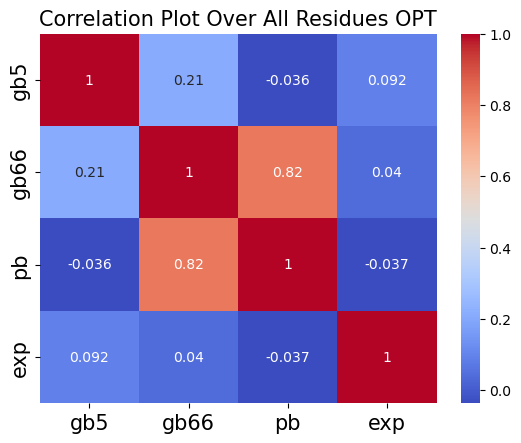

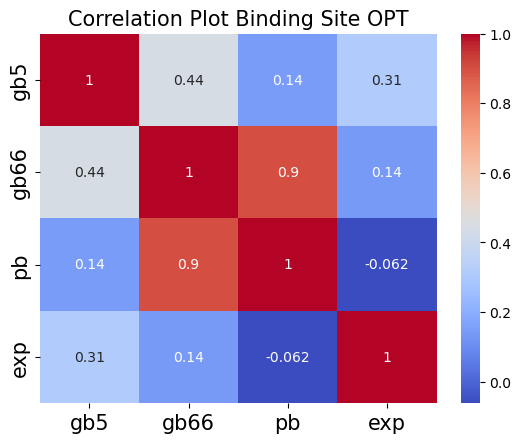

In [57]:
corr_plot_gen("OPT", df_num_data_sorted_OPT, \
    df_num_data_sorted_binding_site_OPT)

In [58]:
cols_to_test = ["delta_delta_g_gen","delta_delta_g_gen_66","delta_delta_g_pb","exp_data"]
random_state=0 
print(f"{'Model':<25} {'true pos%' :<10}  {'false pos%':<10} {'num_clust':<10}")
num_clust_arr = [2,3,4,5,6,7]
for num_clust in num_clust_arr : 
    for col in cols_to_test :
        model_accuracy, model_accuracy_FP, num_clust_out = smple_clust("OPT", col, \
            df_num_data_sorted_OPT, df_num_data_sorted_binding_site_OPT , \
                df_num_data_sorted_no_binding_site_OPT, binding_site_idx_OPT, \
                    num_clust=num_clust)
        print(f"{col:<25}: {model_accuracy:<10.4}: {model_accuracy_FP:<10.4} : {num_clust_out}")
    print("-----------------------------------------------------")

Model                     true pos%   false pos% num_clust 
delta_delta_g_gen        : 12.5      : 96.4       : 2
delta_delta_g_gen_66     : 68.75     : 100.0      : 2
delta_delta_g_pb         : 37.5      : 100.0      : 2
exp_data                 : 18.75     : 87.77      : 2
-----------------------------------------------------
delta_delta_g_gen        : 68.75     : 84.89      : 3
delta_delta_g_gen_66     : 68.75     : 100.0      : 3
delta_delta_g_pb         : 75.0      : 89.93      : 3
exp_data                 : 31.25     : 69.78      : 3
-----------------------------------------------------
delta_delta_g_gen        : 81.25     : 84.17      : 4
delta_delta_g_gen_66     : 75.0      : 100.0      : 4
delta_delta_g_pb         : 75.0      : 89.93      : 4
exp_data                 : 37.5      : 62.59      : 4
-----------------------------------------------------
delta_delta_g_gen        : 81.25     : 75.54      : 5
delta_delta_g_gen_66     : 81.25     : 92.09      : 5
delta_delta_g_pb      